# Recurrent Vision Project (VS265, Fall 2022)

#### Team Members: Shafeeq Ibraheem, Hansen Lillemark, Jacob Yeung

#### This notebook is a basic CNN model which will train on the MNIST dataset. We will then compare its test accuracy on the MNIST test set and a noisy version of the MNIST test set. 
#### We are expecting the model to perform worse on the noisy test set, as the model has not been trained on noisy data.

In [3]:
# Import libraries for convolutional neural network and data processing
# We will use pytorch to create a convolutional neural network training on MNIST dataset.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchsummary

# Import the MNIST dataset
from torchvision import datasets, transforms

In [4]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

In [5]:
train_data = datasets.MNIST(
    root="data", train=True, download=True, transform=transforms.ToTensor()
)
test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=transforms.ToTensor()
)
print(train_data)
print(train_data.data.size())
print(test_data)
print(test_data.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([10000, 28, 28])


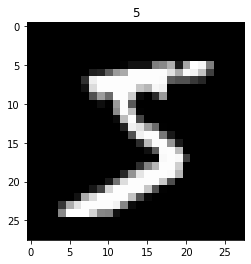

In [6]:
plt.imshow(train_data.data[0], cmap="gray")
plt.title("%i" % train_data.targets[0])
plt.show()

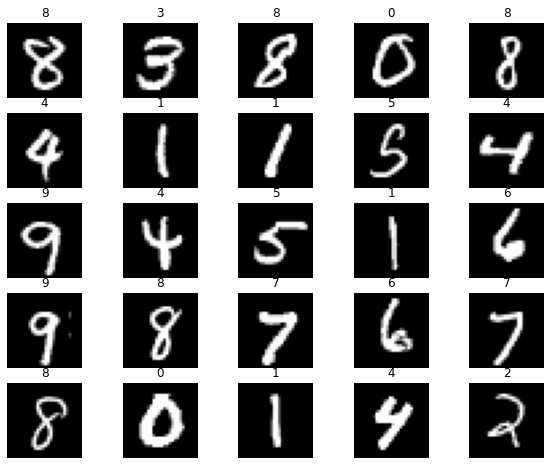

In [7]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [75]:
from torch.utils.data import DataLoader

# train_data.data = train_data.data.float().to(device)
# test_data.data = test_data.data.float().to(device)
loaders = {
    "train": torch.utils.data.DataLoader(
        train_data,
        batch_size=512,
        shuffle=True,
    ),
    "test": torch.utils.data.DataLoader(
        test_data,
        batch_size=512,
        shuffle=True,
    ),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f9b5074bad0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f9b5505d390>}

In [76]:
loaders["train"].dataset.data.size(), type(loaders["train"].dataset.data)

(torch.Size([60000, 28, 28]), torch.Tensor)

In [1]:
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        kernel_size = 3
        padding = 1
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size, 1, padding),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size, 1, padding),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size, 1, padding),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size, 1, padding),
            nn.ReLU(),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(8 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # print(2, x.size())
        x = self.conv3(x)
        # print(3, x.size())
        x = self.conv2(x)
        x = self.conv3(x)
        # x = self.conv4(x)
        # x = self.conv5(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x  # return x for visualization

In [2]:
cnn = CNN().to(device)
print(cnn)

NameError: name 'device' is not defined

In [61]:
# torchsummary.summary(cnn.to("cuda"), (1, 28, 28))

In [62]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [63]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [64]:
train_data.data[0].shape

torch.Size([28, 28])

In [65]:
cnn(train_data.data[0].unsqueeze(0).unsqueeze(0).float().to(device))

(tensor([[ 0.8505, -0.7694,  1.6380,  1.2388, -0.3284,  0.2861,  1.2894,  1.2632,
          -1.4348, -1.5188]], device='cuda:2', grad_fn=<AddmmBackward0>),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.8348, 1.1871]],
        device='cuda:2', grad_fn=<ViewBackward0>))

In [66]:
from torch.autograd import Variable

num_epochs = 10


def train(num_epochs, cnn, loaders):

    cnn.train()

    # Train the model
    total_step = len(loaders["train"])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders["train"]):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).to(device)  # batch x
            b_y = Variable(labels).to(device)  # batch y
            # b_x = images
            # b_y = labels
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch + 1, num_epochs, i + 1, total_step, loss.item()
                    )
                )
            pass
        pass

    pass


train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/118], Loss: 0.2100
Epoch [2/10], Step [100/118], Loss: 0.1135
Epoch [3/10], Step [100/118], Loss: 0.0888
Epoch [4/10], Step [100/118], Loss: 0.0563
Epoch [5/10], Step [100/118], Loss: 0.0332
Epoch [6/10], Step [100/118], Loss: 0.0551
Epoch [7/10], Step [100/118], Loss: 0.0508
Epoch [8/10], Step [100/118], Loss: 0.0221
Epoch [9/10], Step [100/118], Loss: 0.0207
Epoch [10/10], Step [100/118], Loss: 0.0452


In [67]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders["test"]:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            correct += (pred_y == labels).sum().item()
        accuracy = correct / 10000
        print("Test Accuracy of the model on the 10000 test images: %.4f" % accuracy)

    pass


test()

Test Accuracy of the model on the 10000 test images: 0.9850


In [51]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders["test"]:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            correct += (pred_y == labels).sum().item()
        accuracy = correct / 10000
        print("Test Accuracy of the model on the 10000 test images: %.4f" % accuracy)

    pass


test()

Test Accuracy of the model on the 10000 test images: 0.1052


In [19]:
sample = next(iter(loaders["test"]))
imgs, lbls = sample

In [20]:
actual_number = lbls[:10].numpy()
actual_number

array([4, 9, 5, 9, 3, 3, 0, 6, 5, 2])

In [21]:
test_output, last_layer = cnn(imgs[:10].to(device))
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()
print(f"Prediction number: {pred_y}")
print(f"Actual number: {actual_number}")

Prediction number: [4 9 5 9 3 3 0 6 5 2]
Actual number: [4 9 5 9 3 3 0 6 5 2]


In [22]:
# Now we will add some gaussian noise to the test data and see if the performance is still good with the model which is not trained on noisy data.
# We will use the same model which we trained on clean data.


class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + "(mean={0}, std={1})".format(
            self.mean, self.std
        )


test_data_noisy = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            AddGaussianNoise(0.0, 1.0),
        ]
    ),
)

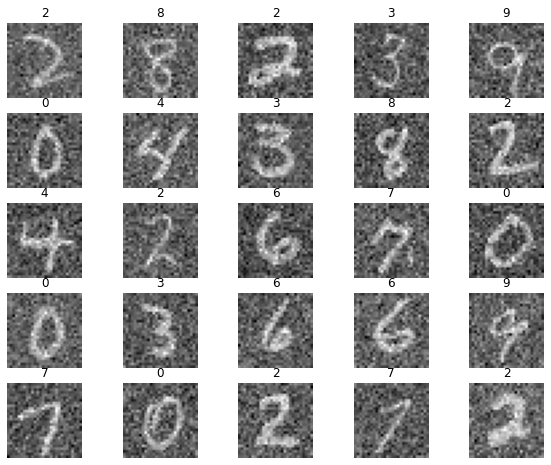

In [23]:
# View some of the noisy data
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data_noisy), size=(1,)).item()
    img, label = test_data_noisy[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [24]:
loaders["test_data_noisy"] = torch.utils.data.DataLoader(
    test_data_noisy, batch_size=10000, shuffle=False, num_workers=1
)
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f9b550cac90>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f9b64b445d0>,
 'test_data_noisy': <torch.utils.data.dataloader.DataLoader at 0x7f9c563204d0>}

In [69]:
def test_noisy():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders["test_data_noisy"]:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
        accuracy = correct / 10000
        print("Test Accuracy of the model on the 10000 test images: %.4f" % accuracy)

    pass


test_noisy()

Test Accuracy of the model on the 10000 test images: 0.3814
